In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
GDrivePath = '/content/drive/MyDrive/'

Mounted at /content/drive/


In [4]:
%ls
%cd /content/drive/MyDrive/
%ls 'Colab Notebooks/CVPR2024/LabLecture3-EstimatingFundamentalMatrix/images'


drive/  sample_data/
/content/drive/MyDrive
govpalace1.jpg  govpalace2.jpg  notredame1.jpg  notredame2.jpg  rushmore1.jpg  rushmore2.jpg


In [5]:

# Function to estimate the fundamental matrix using the eight-point algorithm
def estimate_F(Ma, Mb):
    A = np.zeros((8, 9))
    for ii in range(8):
        A[ii, :] = np.kron(np.hstack([Ma[:, ii], 1]), np.hstack([Mb[:, ii], 1])) #use the kronecker product for building the matrix

    _, _, Vt = np.linalg.svd(A)
    F = Vt[-1, :].reshape(3, 3).T # reshape operates row-wise, thus we need to transpose the result


    # Enforce singularity by zeroing the smallest singular value
    U, S, Vt = np.linalg.svd(F)
    F = U @ np.diag([S[0], S[1], 0]) @ Vt

    return F

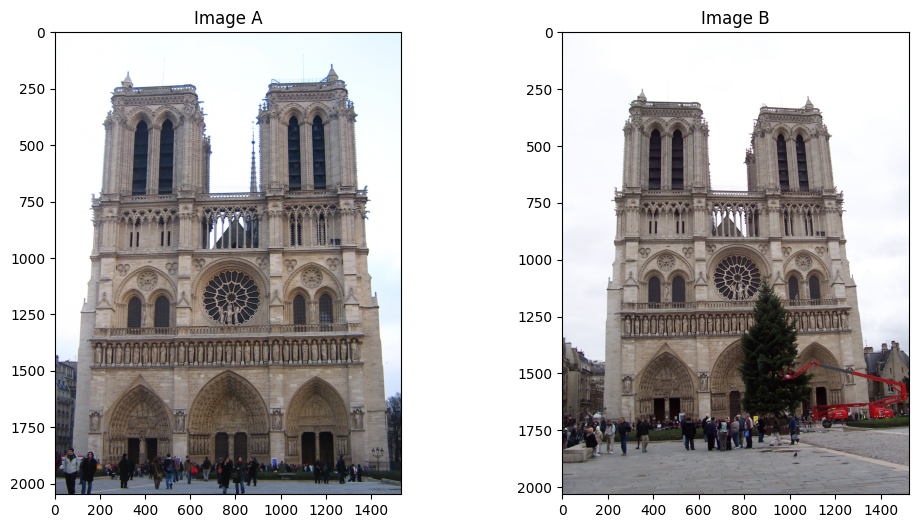

In [6]:
# Load and display images

folderpath = GDrivePath + 'Colab Notebooks/CVPR2023/LabLecture3-EstimatingFundamentalMatrix/images/'

Ia = cv2.imread(folderpath + 'notredame1.jpg')
Ib = cv2.imread(folderpath + 'notredame2.jpg')
#Ia = cv2.imread(folderpath + 'govpalace1.jpg')
#Ib = cv2.imread(folderpath + 'govpalace2.jpg')


scale_factor=1.0  #keep same size

# Get the original image dimensions
height, width = Ia.shape[:2]

# Calculate the new dimensions for scaling
new_width = int(width * scale_factor)
new_height = int(height * scale_factor)

# Resize the image to the new dimensions
Ia = cv2.resize(Ia, (new_width, new_height),interpolation=cv2.INTER_AREA)

# Get the original image dimensions
height, width = Ib.shape[:2]

# Calculate the new dimensions for scaling

new_width = int(width * scale_factor)
new_height = int(height * scale_factor)

# Resize the image to the new dimensions
Ib = cv2.resize(Ib, (new_width, new_height),interpolation=cv2.INTER_AREA)



# Display images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(Ia, cv2.COLOR_BGR2RGB))
plt.title('Image A')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(Ib, cv2.COLOR_BGR2RGB))
plt.title('Image B')

plt.show()


In [7]:

# Convert to grayscale
Ia_gray = cv2.cvtColor(Ia, cv2.COLOR_BGR2GRAY)
Ib_gray = cv2.cvtColor(Ib, cv2.COLOR_BGR2GRAY)


In [8]:

# Detect keypoints using SURF
sift = cv2.SIFT_create(5000)
points_a, descriptors_a = sift.detectAndCompute(Ia_gray, None)
points_b, descriptors_b = sift.detectAndCompute(Ib_gray, None)

# Visualize the keypoints
plt.figure(figsize=(25, 25))


plt.subplot(1, 2, 1)
img_keypoints_a = cv2.drawKeypoints(Ia, points_a, outImage=None,color=(0,0,255), flags=0)
plt.imshow(cv2.cvtColor(img_keypoints_a, cv2.COLOR_BGR2RGB))
plt.title('Image A Keypoints')

plt.subplot(1, 2, 2)
img_keypoints_b = cv2.drawKeypoints(Ib, points_b, None, color=(0,0,255),flags=0)
plt.imshow(cv2.cvtColor(img_keypoints_b, cv2.COLOR_BGR2RGB))
plt.title('Image B Keypoints')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [9]:

# Matching keypoints using nearest neighbor distance ratio
bf = cv2.BFMatcher()

matches = bf.knnMatch(descriptors_a, descriptors_b, k=2) # find the two nearest neighbors

# matches is a tuple:
# matches[i][0] contains the best match for keypoint i
# matches[i][1] contains the second bast match for keypoint i
# each match is a DMatch object, containing
# - the INDICES of the matched pairs, e.g., matches[i][j].queryIdx, matches[i][j].trainIdx
# - the DISTANCE matches[i][j].distance

# Apply ratio test: a match is accepted if the distance is less than a fraction of the distance of the second best match
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

# Extract matched keypoints
XYmatched_a = np.array([points_a[match.queryIdx].pt for match in good])
XYmatched_b = np.array([points_b[match.trainIdx].pt for match in good])

# Show matches
plt.figure(figsize=(25, 25))
plt.imshow(cv2.drawMatches(Ia, points_a, Ib, points_b, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))

plt.title('Matches')

plt.show()


# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract matched keypoints
XYmatched_a = np.array([points_a[match.queryIdx].pt for match in good])
XYmatched_b = np.array([points_b[match.trainIdx].pt for match in good])

# Show matches
plt.figure(figsize=(25, 25))
plt.imshow(cv2.drawMatches(Ia, points_a, Ib, points_b, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
#plt.imshow(cv2.drawMatchesKnn(Ia, points_a, Ib, points_b, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.title('Matches')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [10]:
# RANSAC for robust estimation of the fundamental matrix
ransac_th = 0.002  # algebraic threshold
ntrials = 1000
FF = np.zeros((3, 3, ntrials))
consensus = np.zeros(ntrials)

for ii in range(ntrials):
    selected = np.random.choice(len(good), 8, replace=False)

    # Get selected keypoints
    Ma = XYmatched_a[selected, :].T
    Mb = XYmatched_b[selected, :].T

    F = estimate_F(Ma, Mb)
    FF[:, :, ii] = F
    consensus[ii] = 0
    for jj in range(len(good)):
        ma=np.append(XYmatched_a[jj, :],1)
        mb=np.append(XYmatched_b[jj, :],1)
        if np.abs(mb@F@np.atleast_2d(ma).T) < ransac_th:
            consensus[ii] +=1

plt.figure()
plt.plot(consensus)

# Find the winning F
imax = np.argmax(consensus)
F = FF[:, :, imax]

# Discard outliers
XYmatched_a_ones=np.hstack( (XYmatched_a,np.ones([XYmatched_a.shape[0],1])))
XYmatched_b_ones=np.hstack( (XYmatched_b,np.ones([XYmatched_b.shape[0],1])))

inliers = np.abs( np.diag(XYmatched_b_ones@F@XYmatched_a_ones.T) ) < ransac_th
#XYmatched_a_inliers = XYmatched_a[inliers]
#XYmatched_b_inliers = XYmatched_b[inliers]

# Visualize inliers
plt.figure(figsize=(25, 25))
img_inliers = cv2.drawMatches(Ia, points_a, Ib, points_b, [good[i] for i in np.where(inliers)[0].tolist()], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(img_inliers, cv2.COLOR_BGR2RGB))
plt.title('Inliers')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Homework

Instead of the algebraic criterion use a *geometric criterion* for spotting
 the outliers:
 * implement a criterion based on both the distance of $m'_b$ from  the epipolar line corresponding to $m'_a$ and the distance of $m'_a$ from the
 epipolar line corresponding to $m'_b$. Recall that, given a line $ax+by+c=0$,
 the distance from the point $u,v$ to the line is $|au+bv+c|$ provided that $a^2+b^2$=1.
 * implement the *normalized eight point algorithm* and compare the results
 with the un-normalized case.

In [11]:
# RANSAC for robust estimation of the fundamental matrix
ransac_dist_th = .5  # pixel
ntrials = 2000
FF = np.zeros((3, 3, ntrials))
consensus = np.zeros(ntrials)

for ii in range(ntrials):
    selected = np.random.choice(len(good), 8, replace=False)

    # Get selected keypoints
    Ma = XYmatched_a[selected, :].T
    Mb = XYmatched_b[selected, :].T

    F = estimate_F(Ma, Mb)

    FF[:, :, ii] = F
    consensus[ii] = 0

    for jj in range(len(good)):
        ma=np.append(XYmatched_a[jj, :],1)
        mb=np.append(XYmatched_b[jj, :],1)

        lambda_a=F@np.atleast_2d(ma).T
        lambda_a=lambda_a/(np.linalg.norm(lambda_a[0:2]))

        lambda_b=F.T@np.atleast_2d(mb).T
        lambda_b=lambda_b/(np.linalg.norm(lambda_b[0:2]))

        # epipolar line in Ia is given by the equation: [x y 1]*lambda=0
        if np.abs(mb@lambda_a) < ransac_dist_th and np.abs(ma@lambda_b) < ransac_dist_th:
            consensus[ii] +=1

plt.figure()
plt.plot(consensus)

# Find the winning F
imax = np.argmax(consensus)
F = FF[:, :, imax]

# Discard outliers
inliers=[]

for jj in range(len(good)):
    ma=np.append(XYmatched_a[jj, :],1)
    mb=np.append(XYmatched_b[jj, :],1)

    lambda_a=F@np.atleast_2d(ma).T
    lambda_a=lambda_a/(np.linalg.norm(lambda_a[0:2]))

    lambda_b=F.T@np.atleast_2d(mb).T
    lambda_b=lambda_b/(np.linalg.norm(lambda_b[0:2]))

    # epipolar line in Ia is given by the equation: [x y 1]*lambda=0
    if np.abs(mb@lambda_a) < ransac_dist_th and np.abs(ma@lambda_b) < ransac_dist_th:
        inliers.append(True)
    else:
        inliers.append(False)


# Visualize inliers
plt.figure(figsize=(25, 25))
img_inliers = cv2.drawMatches(Ia, points_a, Ib, points_b, [good[i] for i in np.where(inliers)[0].tolist()], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(img_inliers, cv2.COLOR_BGR2RGB))
plt.title('Inliers')

plt.show()

Output hidden; open in https://colab.research.google.com to view.